In [389]:
 %config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import pickle

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import patsy
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [390]:
pickle_in = open("all_feature_counts.pickle","rb")
counts = pickle.load(pickle_in)
pickle_in = open("all_feature_means.pickle","rb")
vital_means = pickle.load(pickle_in)

## Preliminary EDA 

In [391]:
#Some data cleaning (eliminate some sparse features, drop nulls)
important_vitals = vital_means.drop(columns = ['ALP', 'ALT', 'AST','Albumin','Bilirubin','Height',
                                               'Gender','Cholesterol','RespRate', 'TroponinI', 'TroponinT','SaO2'])
important_vitals['RecordID'] = important_vitals['RecordID'].astype(int)
for_impute = important_vitals
important_vitals = important_vitals.dropna()

Combining data with outcomes to begin modeling

In [392]:
with open("data/Outcomes-a.txt") as f:
    content = f.readlines()
    contents = [i.rstrip().split(',') for i in content[1:]]
outcomes = [[i[0],i[5]] for i in contents]

In [393]:
outcomes = pd.DataFrame(outcomes)
outcomes = outcomes.rename(columns = {0:'RecordID',1:'Outcome'})
outcomes = outcomes.astype(int)
combined = pd.merge(important_vitals, outcomes, on='RecordID', how='inner')

In [394]:
#Functions for modeling
def scale(X_train, X_test, X_val = np.empty([0,])):
    std = StandardScaler()
    std.fit(X_train.values)
    pickle.dump(std, open("scaler.p","wb"))
    X_tr = std.transform(X_train.values)
    X_te = std.transform(X_test.values)
    
    #When I want to test the set and the data
    if X_val.size != 0 :
        X_va = std.transform(X_val.values)
        return X_tr, X_te, X_va
    return X_tr, X_te


In [395]:
y = combined['Outcome']
X = combined.drop(columns = ['Outcome','RecordID'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [396]:
#SCORING METRICS GIVEN CONFUSION MATRIX
def precision(matrix):
    if (matrix[1][1]+matrix[0][1]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[0][1])

def recall(matrix):
    if (matrix[1][1]+matrix[1][0]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[1][0])

def minScore(matrix):
    return min(precision(matrix),recall(matrix))

In [397]:
def print_heatmap(confusion):
    plt.figure(dpi=100)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

    plt.xlabel('Predicted Mortality')
    plt.ylabel('Actual Mortality')
    plt.title('Confusion Matrix');

In [398]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_te, y_test)))

The score for kNN is
Training:  82.39%
Test set:  73.77%


In [399]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_te, y_test)))

The score for logistic regression is
Training:  78.40%
Test set:  74.86%


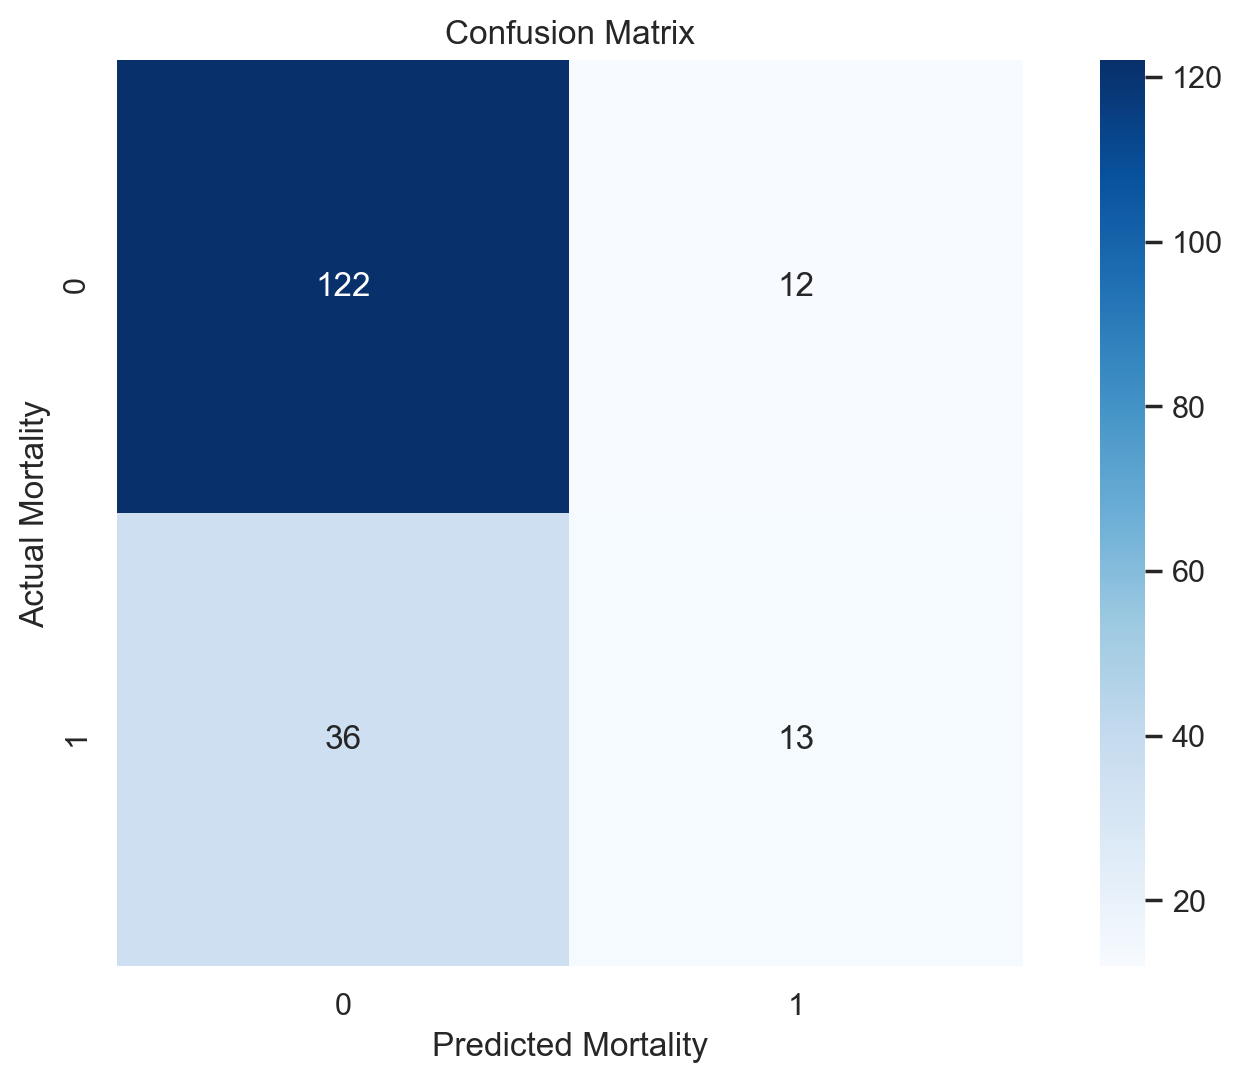

In [400]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_te))
print_heatmap(knn_confusion)

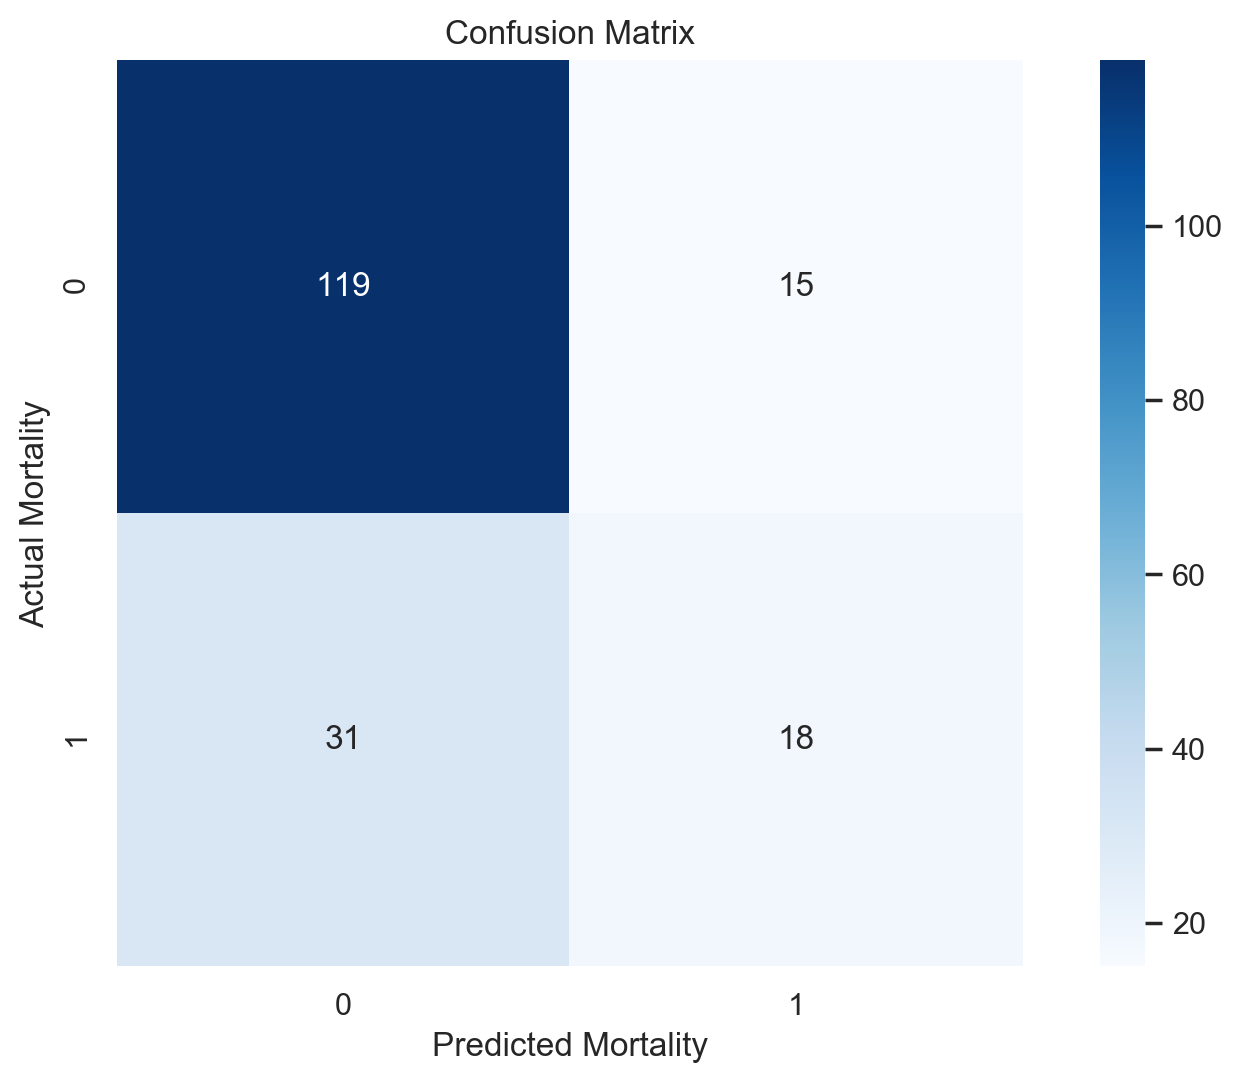

In [401]:
logit_confusion = confusion_matrix(y_test, logit.predict(X_te))
print_heatmap(logit_confusion)

In [402]:
15/(15+119)

0.11194029850746269

## Scoring <br>


In [403]:
def make_confusion_matrix(model, threshold, X, y):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    return confusion_matrix(y, y_predict) 

#Score for a given threshold
def min_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return min(precision_score(y, y_predict), recall_score(y, y_predict))

#f1 score for a given threshold
def f1_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return f1_score(y, y_predict)

In [404]:
#Find threshold to maximize contest score. Use train set, then maximize threshold on test set.
def max_score(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = min_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

In [405]:
#Find threshold to maximize contest score. Use train set, then maximize threshold on test set.
def max_f1(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = f1_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

In [406]:
def print_score(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_score(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

In [407]:
def print_f1(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_f1(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

In [408]:
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  56.58% at a threshold of 0.119


In [409]:
x = np.array([[0,0],[0,100]])

[Text(0, 0.5, 'Alive'), Text(0, 1.5, 'Dead')]

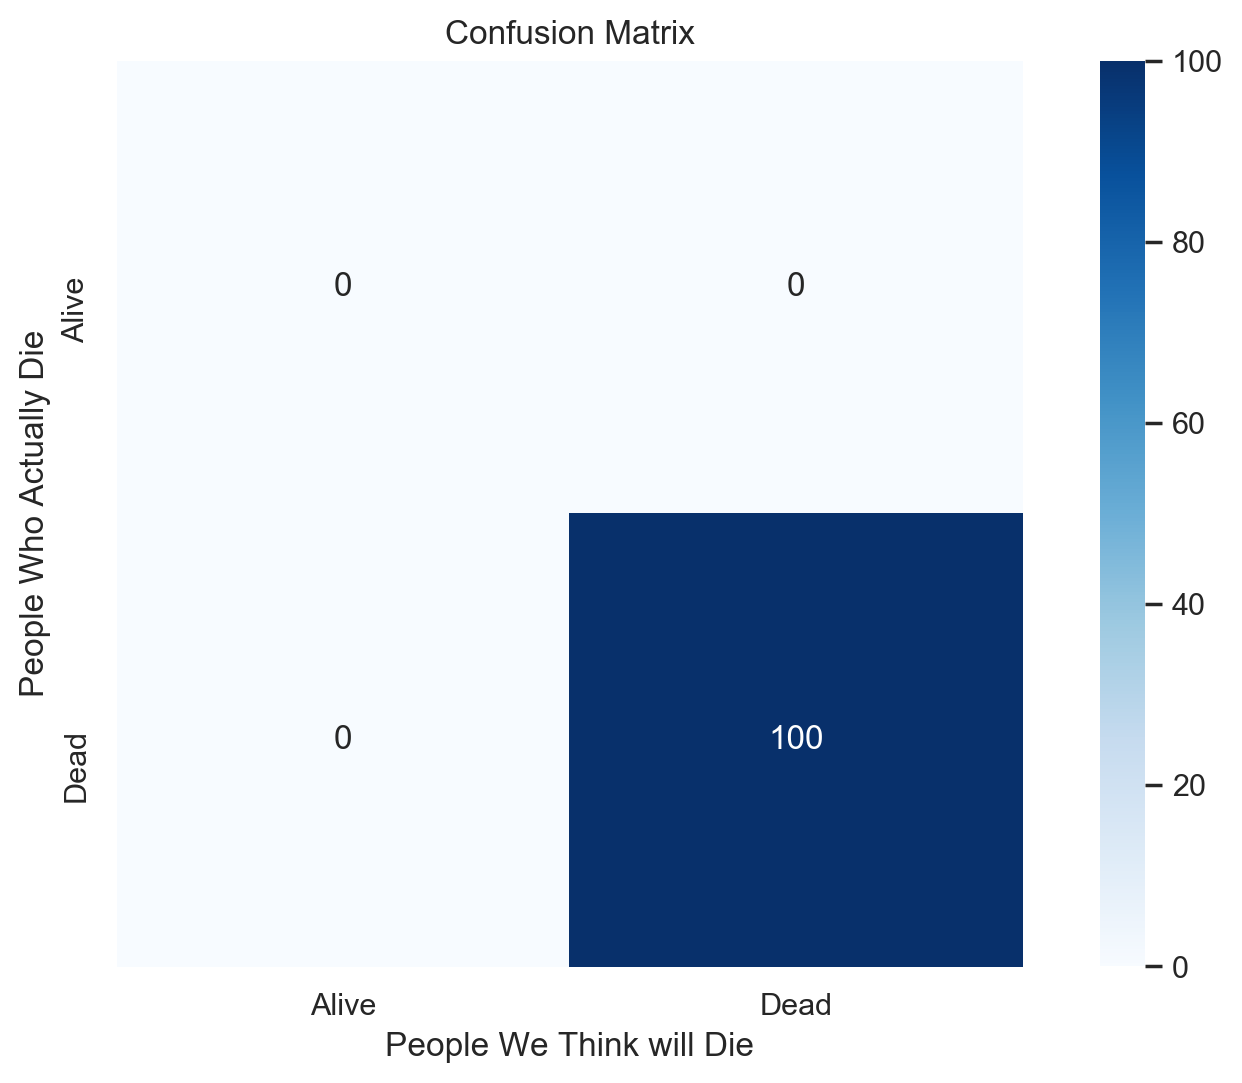

In [410]:
    plt.figure(dpi=100)
    ax = sns.heatmap(x, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

    plt.xlabel('People We Think will Die')
    plt.ylabel('People Who Actually Die')
    plt.title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Alive','Dead'])
    ax.yaxis.set_ticklabels(['Alive','Dead'])

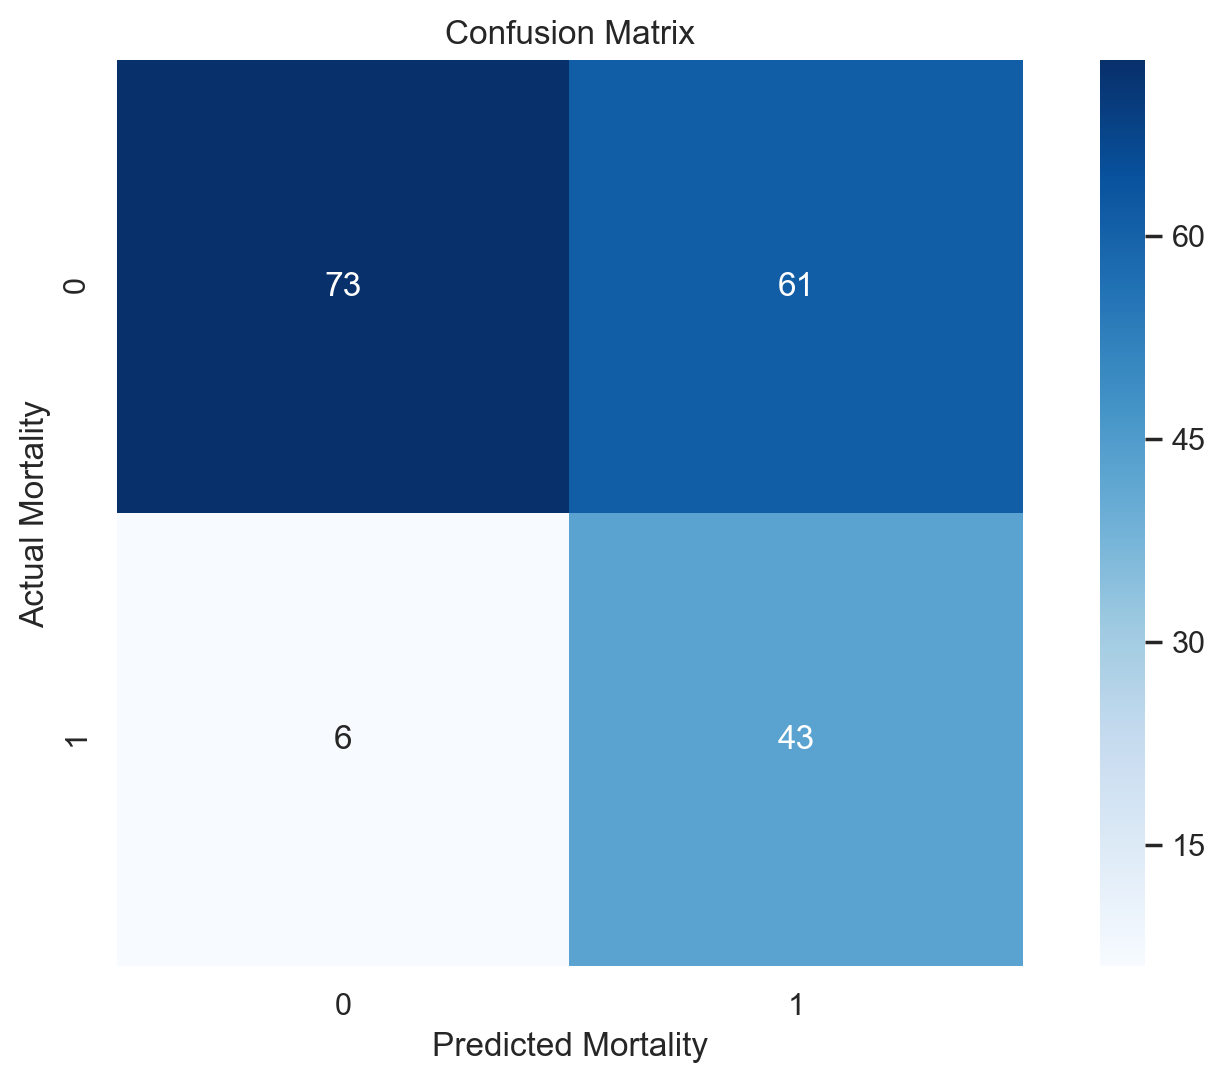

In [411]:
logit_confusion2 = make_confusion_matrix(logit, .119, X_te, y_test)
print_heatmap(logit_confusion2)

In [412]:
939/(939+2150)

0.30398187115571385

### Feature Selection 
First I tried using Recursive Feature Elimination to find features, but I would ultimately be able to get a better test prediction manually selecting features (based off OLS and Lasso), so I would abandon RFE.

In [413]:
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs'), n_features_to_select=14, step=10, verbose=5)
rfe_selector.fit(X_tr, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 30 features.
Fitting estimator with 20 features.
14 selected features


In [414]:
rfe_feature

['',
 'Age',
 'BUN',
 'Creatinine',
 'FiO2',
 'GCS',
 'HCO3',
 'HR',
 'Mg',
 'NISysABP',
 'PaCO2',
 'Temp',
 'Urine',
 'Weight']

In [415]:
pickle_out = open("combined.pickle","wb")
pickle.dump(combined, pickle_out)
pickle_out.close()

In [416]:
pickle_in = open("Combined.pickle","rb")
combined = pickle.load(pickle_in)

In [417]:
yXstring = 'Outcome ~ Age + BUN + Creatinine + DiasABP + FiO2 + GCS + Glucose + HCO3 +HCT + HR + ICUType + K + Lactate + MAP + MechVent + Mg +NIDiasABP + NIMAP + NISysABP + Na + PaCO2 + PaO2 + Platelets + SysABP + Temp + Urine + WBC + Weight + pH'
y, X = patsy.dmatrices(yXstring, data=combined, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     6.972
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           1.23e-22
Time:                        03:52:30   Log-Likelihood:                -288.67
No. Observations:                 609   AIC:                             635.3
Df Residuals:                     580   BIC:                             763.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0966      2.251      0.043      0.966      -4.324       4.517
Age            0.0048      0.001      4.331      0.000       0.003       0.007
BUN            0.0026      0.001      2.081      0.038       0.000       0.005
Creatinine    -0.0218      0.019     -1.154      0.249      -0.059       0.015
DiasABP        0.0022      0.004      0.501      0.617      -0.007       0.011
FiO2           0.1717      0.147      1.167      0.244      -0.117       0.461
GCS           -0.0539      0.006     -8.729      0.000      -0.066      -0.042
Glucose     7.135e-05      0.000      0.159      0.874      -0.001       0.001
HCO3           0.0044      0.011      0.405      0.685      -0.017       0.026
HCT           -0.0029      0.004     -0.726      0.468      -0.011       0.005
HR             0.0034      0.001      2.664      0.008       0.001       0.006
ICUType        0.0412      0.019      2.204      0.028       0.004       0.078
K              0.0042      0.040      0.105      0.917      -0.075       0.083
Lactate        0.0223      0.010      2.345      0.019       0.004       0.041
MAP           -0.0030      0.004     -0.683      0.495      -0.012       0.006
MechVent       0.0966      2.251      0.043      0.966      -4.324       4.517
Mg            -0.0243      0.054     -0.450      0.653      -0.131       0.082
NIDiasABP      0.0028      0.003      1.025      0.306      -0.003       0.008
NIMAP         -0.0044      0.003     -1.442      0.150      -0.010       0.002
NISysABP       0.0029      0.002      1.786      0.075      -0.000       0.006
Na             0.0002      0.004      0.043      0.966      -0.007       0.007
PaCO2         -0.0031      0.006     -0.499      0.618      -0.016       0.009
PaO2          -0.0001      0.000     -0.362      0.717      -0.001       0.001
Platelets   5.193e-05      0.000      0.312      0.755      -0.000       0.000
SysABP        -0.0016      0.002     -0.862      0.389      -0.005       0.002
Temp          -0.0825      0.025     -3.320      0.001      -0.131      -0.034
Urine         -0.0004      0.000     -1.500      0.134      -0.001       0.000
WBC            0.0006      0.002      0.265      0.791      -0.004       0.005
Weight        -0.0018      0.001     -2.563      0.011      -0.003      -0.000
pH             0.4274      0.593      0.721      0.471      -0.737       1.592
==============================================================================
Omnibus:                       52.587   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.379
Skew:                           0.568   Prob(JB):                     3.80e-10
Kurtosis:                       2.353   Cond. No.                     3.19e+15
==============================================================================

W

Let's see if we can improve the model by dropping some columns.

In [418]:
combinedDropped = combined.drop(columns = ['Creatinine','DiasABP','FiO2','Glucose', 'HCO3','K','MAP','MechVent','Mg','Na','NIMAP','NISysABP','NIDiasABP','Platelets','Temp','PaO2', 'SysABP','WBC'])

In [419]:
y = combinedDropped['Outcome']
X = combinedDropped.drop(columns = ['Outcome','RecordID'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [420]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print_f1(knn, X_te, y_test)

The max score for KNeighborsClassifier is
Test set:  48.68% at a threshold of 0.001


In [421]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  57.75% at a threshold of 0.197


Our model improved significantly by dropping collinear columns! Interesting. <br>
Removing these columns actually improved the logistic regression by a slight amount, while KNN was predictably unaffected.

In [422]:
#Bring in combined data with these features
pickle_in = open("all_train.pickle","rb")
all_train = pickle.load(pickle_in)

In [423]:
X, y= all_train.drop(columns = ['Outcome']), all_train['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [424]:
logit_all = LogisticRegression(solver = 'lbfgs')
logit_all.fit(X_tr, y_train)
print_f1(logit_all, X_te, y_test)

The max score for LogisticRegression is
Test set:  47.84% at a threshold of 0.244


In [425]:
coefs = pd.DataFrame(list(zip(X_train.columns,list(logit_all.coef_[0]))))

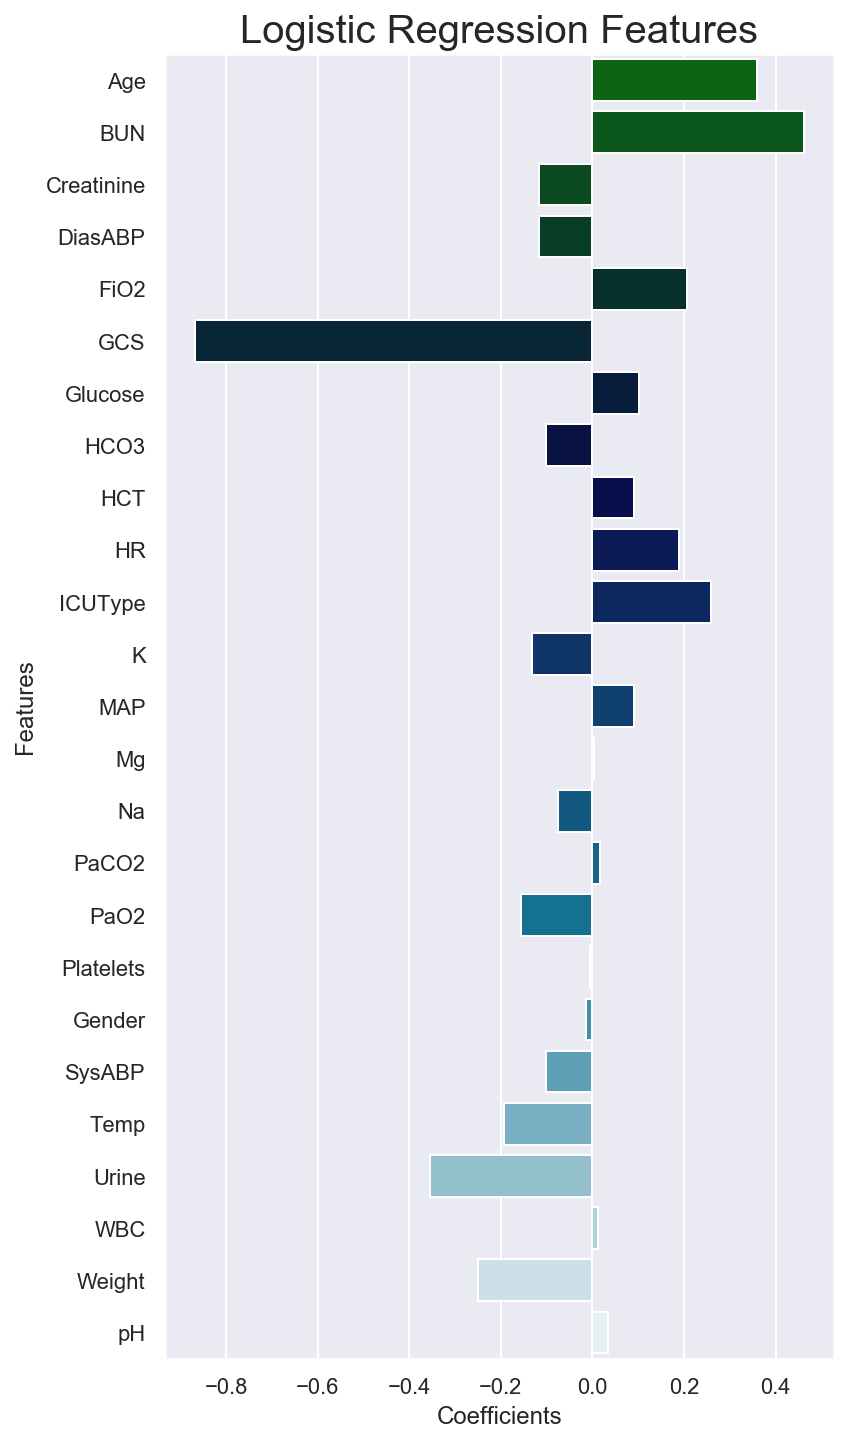

In [426]:
import seaborn as sns
plt.figure(figsize=(6,12))
sns.set(font_scale = 1)
ax = sns.barplot(x = coefs[1], y=coefs[0], palette = 'ocean');
plt.title("Logistic Regression Features", fontsize=20)
ax.set(ylabel='Features', xlabel = 'Coefficients');

This is the best score yet, and Logistic Regression will ultimately prove to be a reliable model.

In [427]:
#Testing Naive Bayes, not quite as good as logistic regression here
nb_all = BernoulliNB()
nb_all.fit(X_tr, y_train)
print_f1(nb_all, X_te, y_test)

The max score for BernoulliNB is
Test set:  39.16% at a threshold of 0.179


## Primary Models

### Grid Search

**Random Forest**

In [346]:
from sklearn.model_selection import GridSearchCV

In [347]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = 2)

In [348]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed: 14.0min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [349]:
rf_all = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features = 3,
 min_samples_leaf= 4,
 min_samples_split= 8,
 n_estimators= 100)

In [428]:
rf_all.fit(X_tr, y_train)
print_f1(rf_all, X_te, y_test)

The max score for RandomForestClassifier is
Test set:  48.79% at a threshold of 0.257


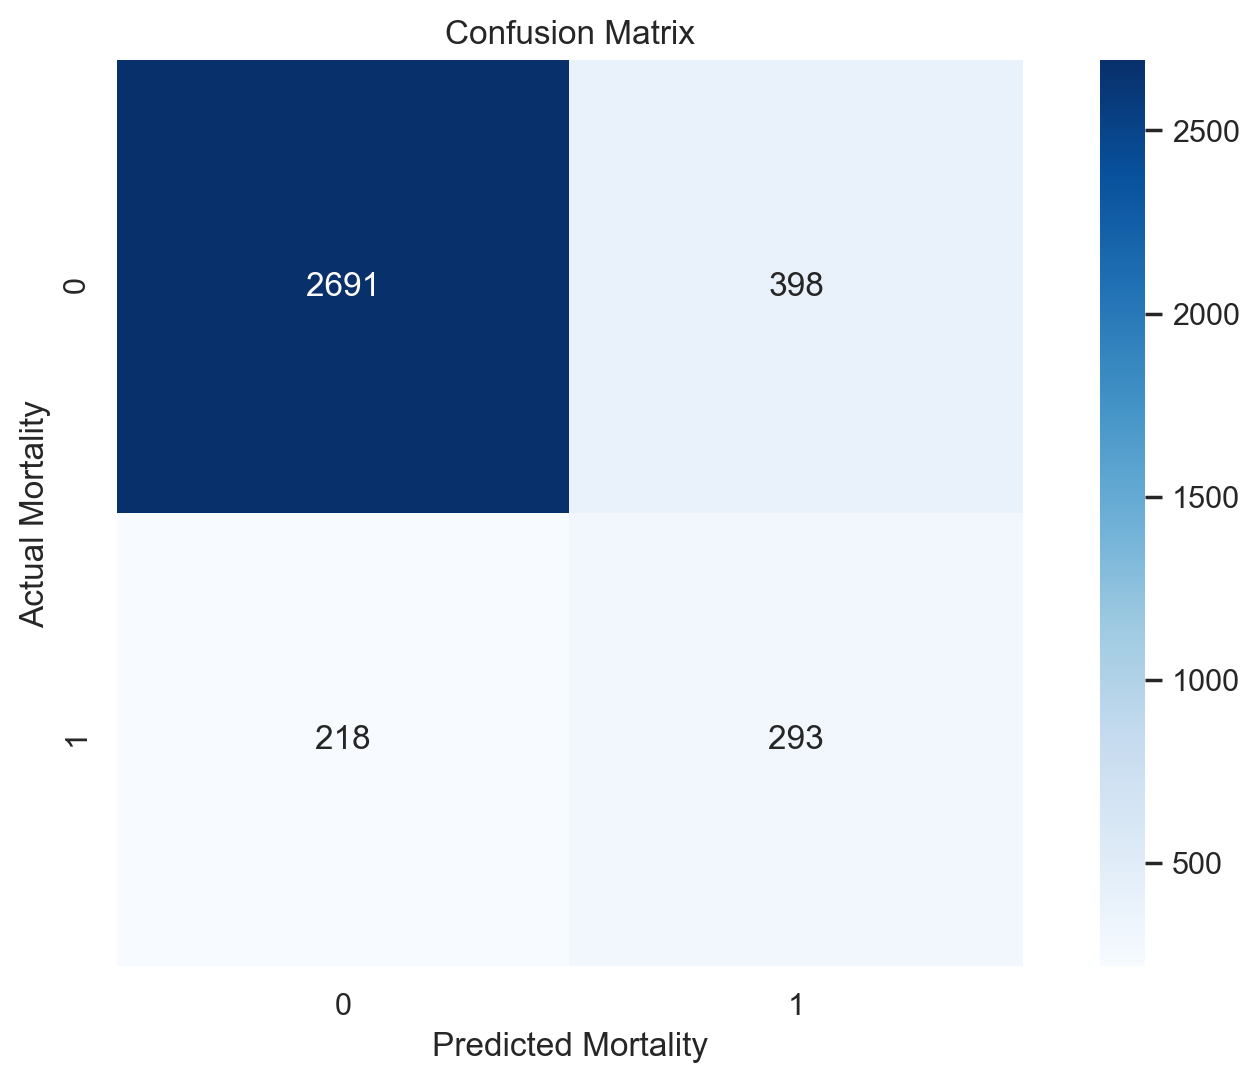

In [429]:
logit_confusion = make_confusion_matrix(rf_all, .257, X_te, y_test)
print_heatmap(logit_confusion)

In [430]:
398/(398+2691)

0.12884428617675622

In [431]:
t,s=max_score(rf_all, X_te, y_test)

In [432]:
fr = pd.DataFrame(sorted(feature_ranks.items(), key=lambda kv:(kv[1], kv[0]), reverse=True))

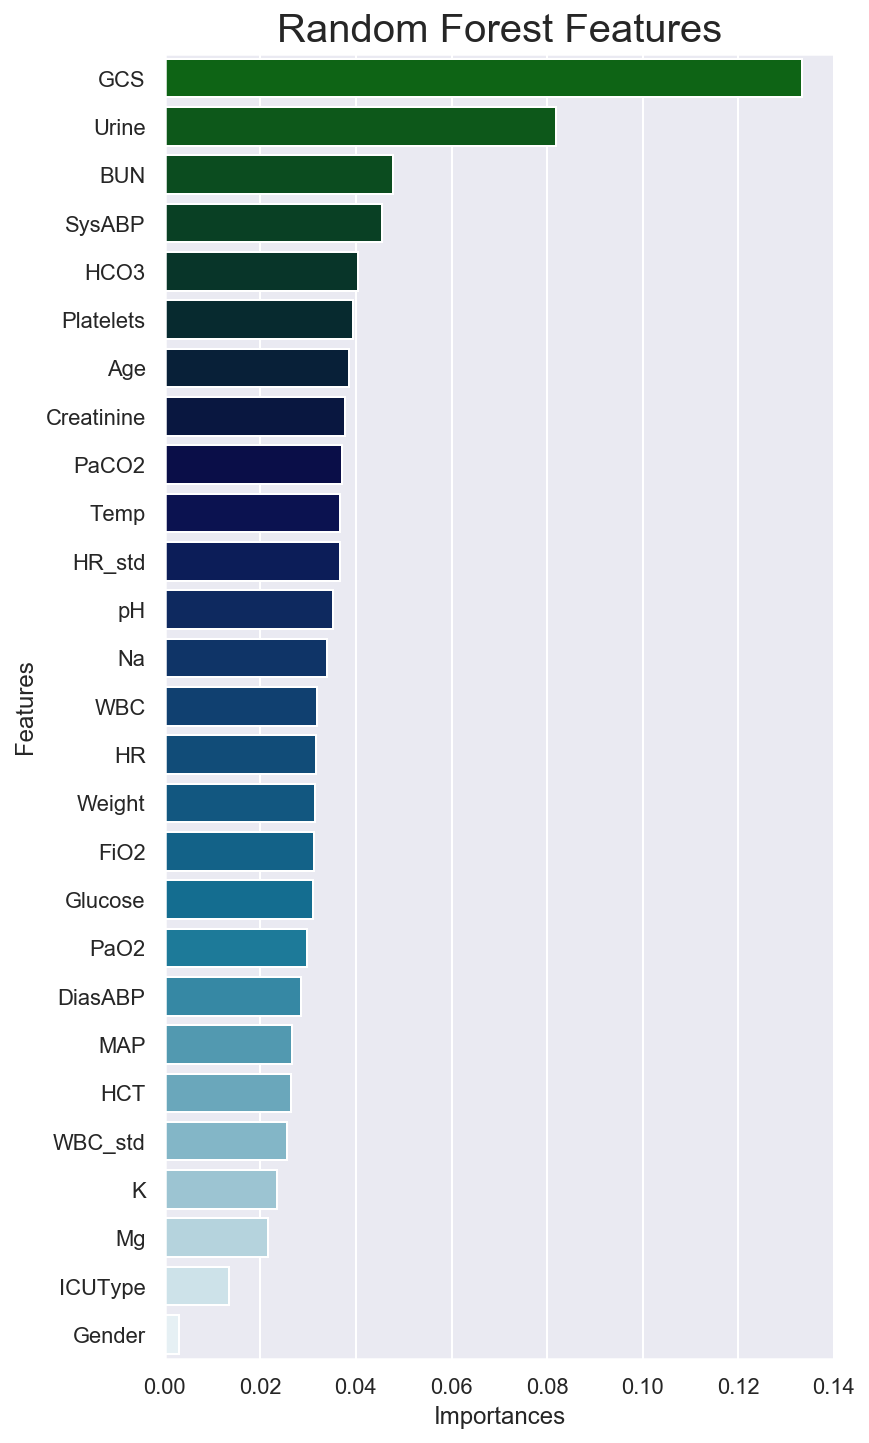

In [433]:
plt.figure(figsize=(6,12))
sns.set(font_scale = 1)
ax = sns.barplot(x = fr[1], y=fr[0], palette = 'ocean');
plt.title("Random Forest Features", fontsize=20)
ax.set(ylabel='Features', xlabel = 'Importances');

In [454]:
vi = list(fr[0])
vi.remove("HR_std")
vi.remove("WBC_std")
p.dump(vi, open("mif.p","wb"))

In [434]:
pickle_out = open("RandomForestModel","wb")
pickle.dump(rf_all, pickle_out)

The RandomForest is a slight improvement over Logistic.

## XGBoost

In [435]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_train);
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  49.16% at a threshold of 0.234


XGBoost to the flipping rescue! Even without gridsearch it beats other models handily.

In [440]:
param_grid = {
    'learning_rate': [.01, .03, .06, .1],
    'subsample': [.8, .85, .9, .95, 1],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [.3, .4, .6, .8, 1],
    'gamma': [0, 1, 5]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = 2)

In [441]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 11.1min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed: 17.5min finished


{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.06,
 'max_depth': 5,
 'subsample': 0.9}

In [442]:
xgb = XGBClassifier(colsample_bytree = 0.6, gamma=0, learning_rate=.06, max_depth=6, subsample=0.85)
xgb.fit(X_tr, y_train);

In [443]:
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  48.87% at a threshold of 0.191


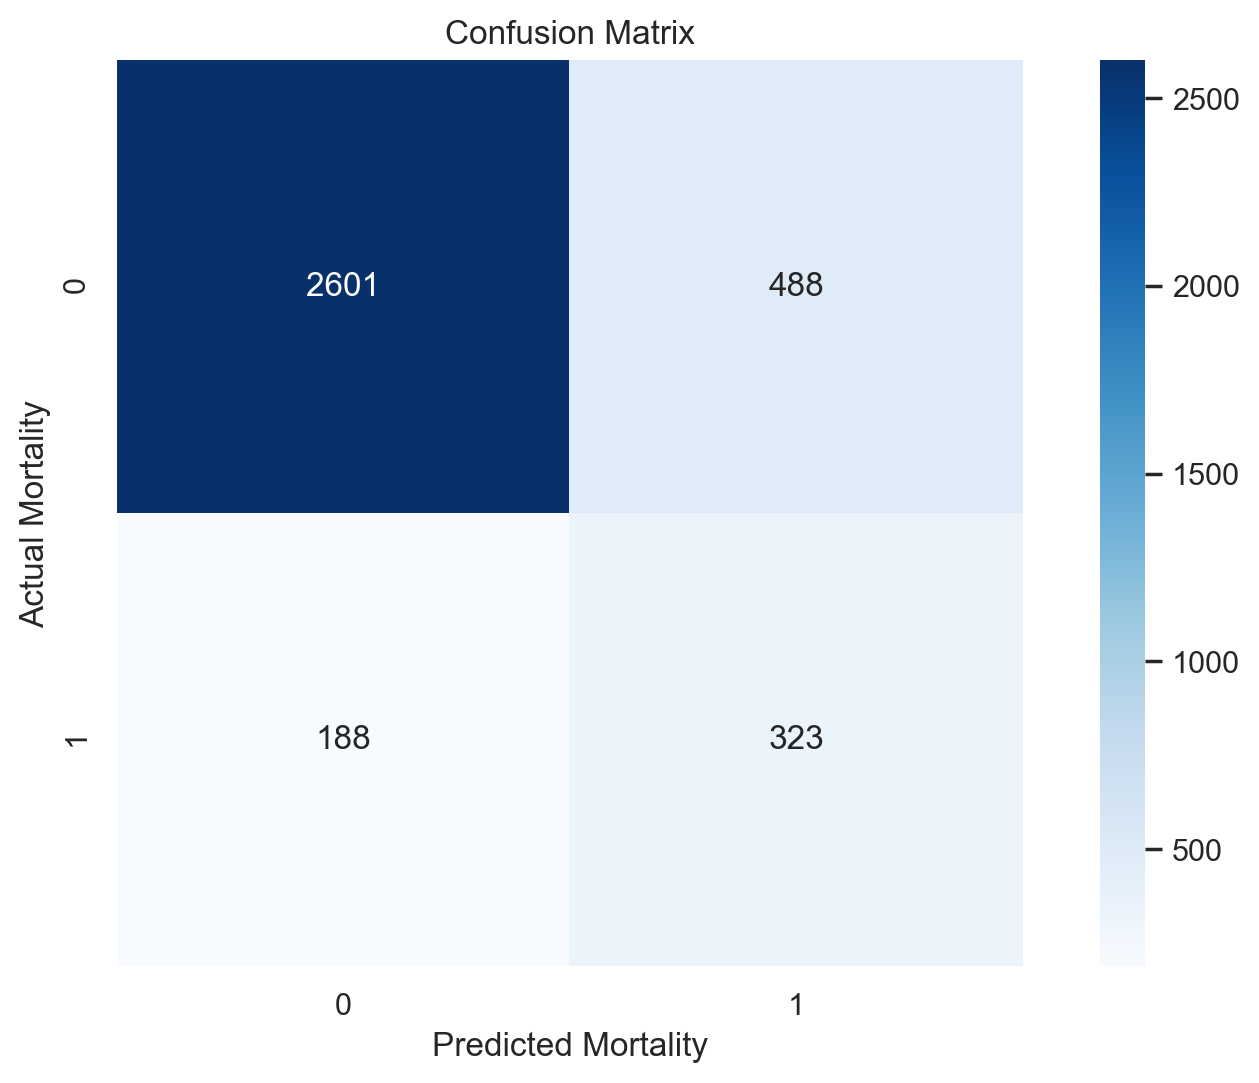

In [444]:
logit_confusion = make_confusion_matrix(xgb, .191, X_te, y_test)
print_heatmap(logit_confusion)

In [439]:
488/(488+2601)

0.1579799287795403

In [364]:
pickle.dump(xgb, open('XGB.pickle.dat',"wb"))

**Logistic Regression**

In [365]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
             'solver' : ['liblinear'],
             'penalty' : ['l1','l2']}

grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5)
grid.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best paramters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.87
Best paramters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [366]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
             'solver' : ['lbfgs']}

grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5)
grid.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best paramters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.87
Best paramters:  {'C': 0.01, 'solver': 'lbfgs'}
Best estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [458]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  47.84% at a threshold of 0.244


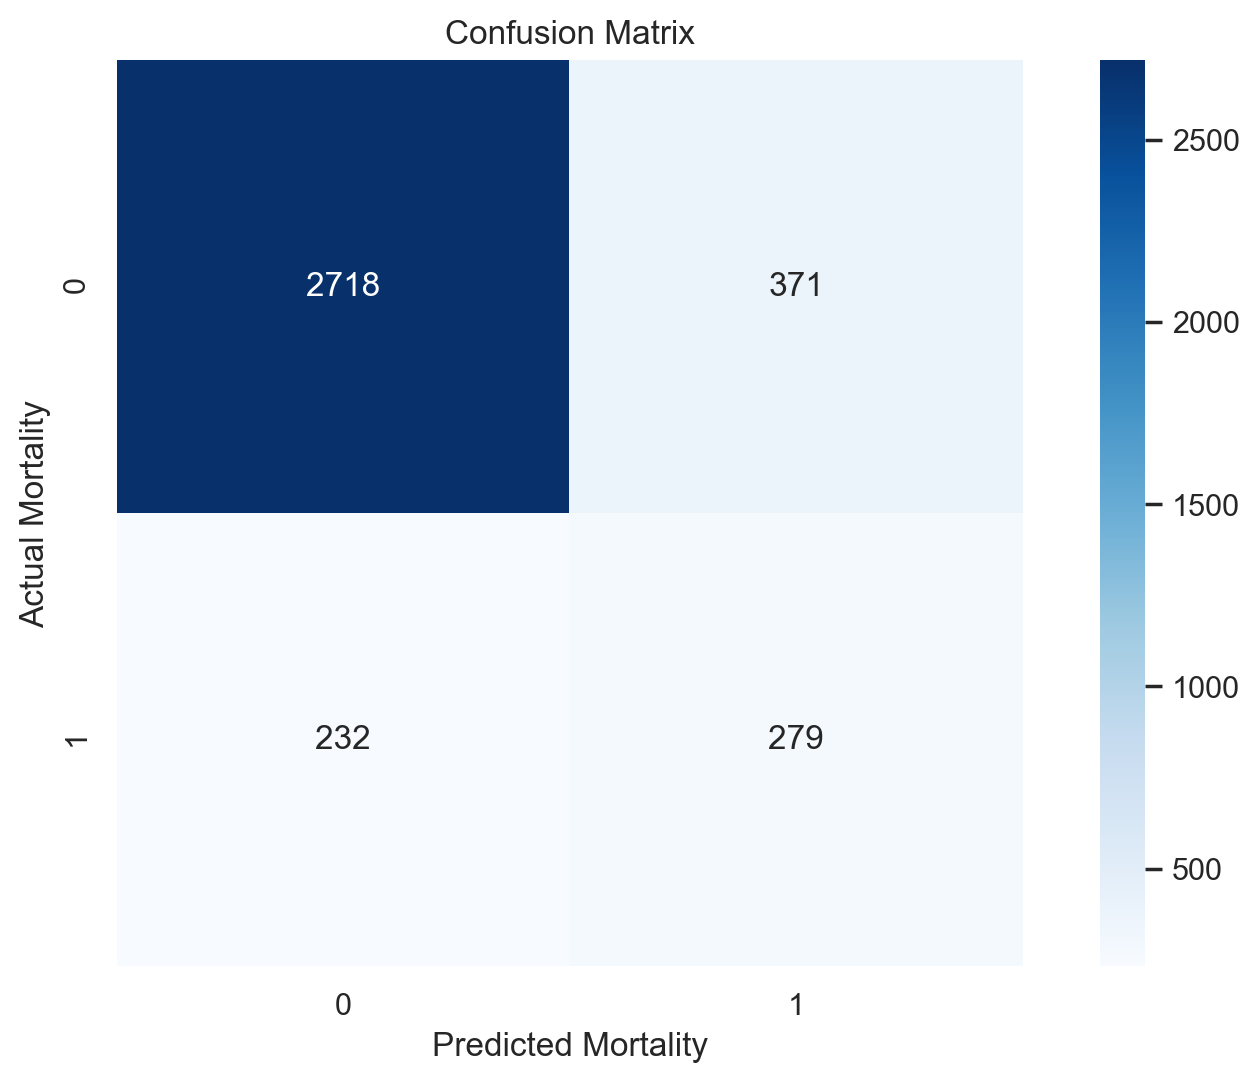

In [459]:
logit_confusion = make_confusion_matrix(xgb, .244, X_te, y_test)
print_heatmap(logit_confusion)

In [460]:
371/(371+2718)

0.12010359339592101

Grid Search is not super helpful with logistic regression. I tried every permutation of LogisticRegression paramaters (L1, L2, Elastinet with different hyperparamaters), but the suggested paramters do worse on the test set. 
**Winner in a landslide is: XGBoost**

### Precision/Recall and ROC Curves

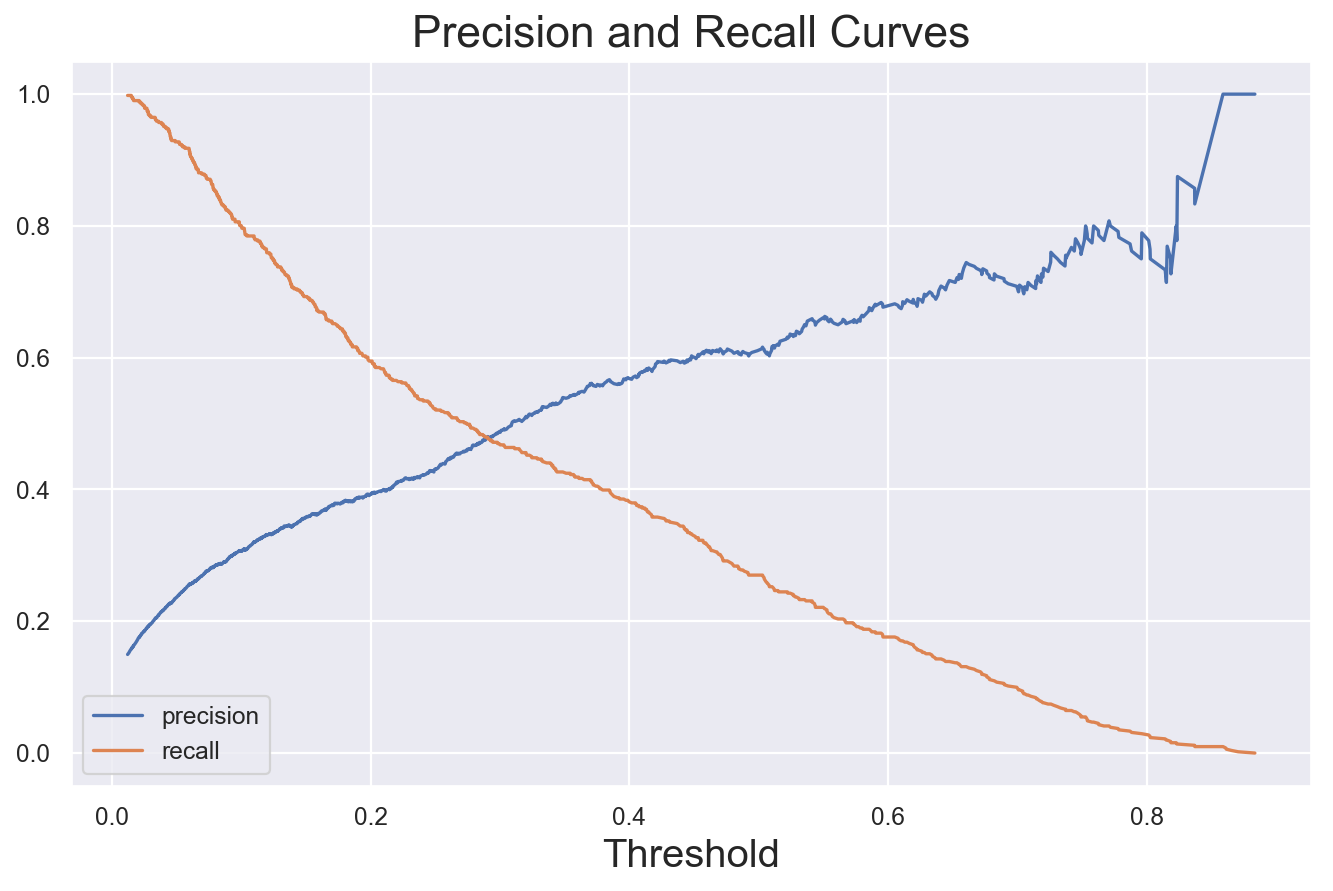

In [367]:
#precision_curve for this latest random forest model
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb.predict_proba(X_te)[:,1] )
plt.figure(dpi=80, figsize=(10,6))

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold', fontsize=18);
plt.title('Precision and Recall Curves', fontsize=20);

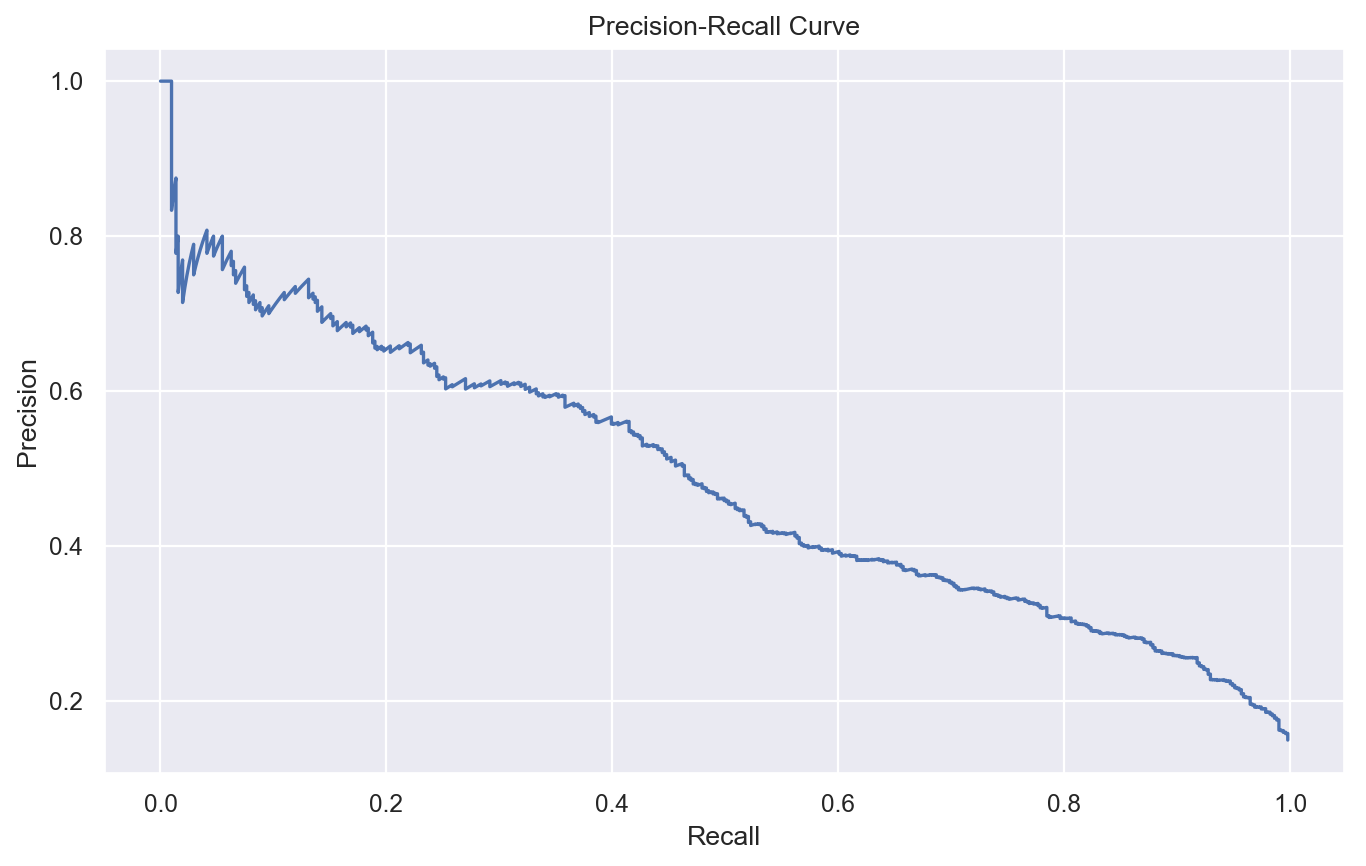

In [368]:
plt.figure(dpi=80, figsize=(10,6))
plt.rcParams['figure.figsize'] = (10.0, 6)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [369]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [370]:
def plot_AUC(X, y, model):
    fpr, tpr, thresh = metrics.roc_curve(y, model.predict_proba(X)[:,1])
    auc = metrics.roc_auc_score(y, model.predict_proba(X)[:,1])
    plt.plot(fpr,tpr,label=type(model).__name__)
    plt.plot([0,1],[0,1],ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc=4);
    
    plt.xlabel('False positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.title('ROC curve for Mortality Prediction', fontsize=22);
    print(type(model).__name__ + " ROC AUC score : {:f}".format(roc_auc_score(y, model.predict_proba(X)[:,1])))

XGBClassifier ROC AUC score : 0.834934
RandomForestClassifier ROC AUC score : 0.831175
LogisticRegression ROC AUC score : 0.810974
BernoulliNB ROC AUC score : 0.756273


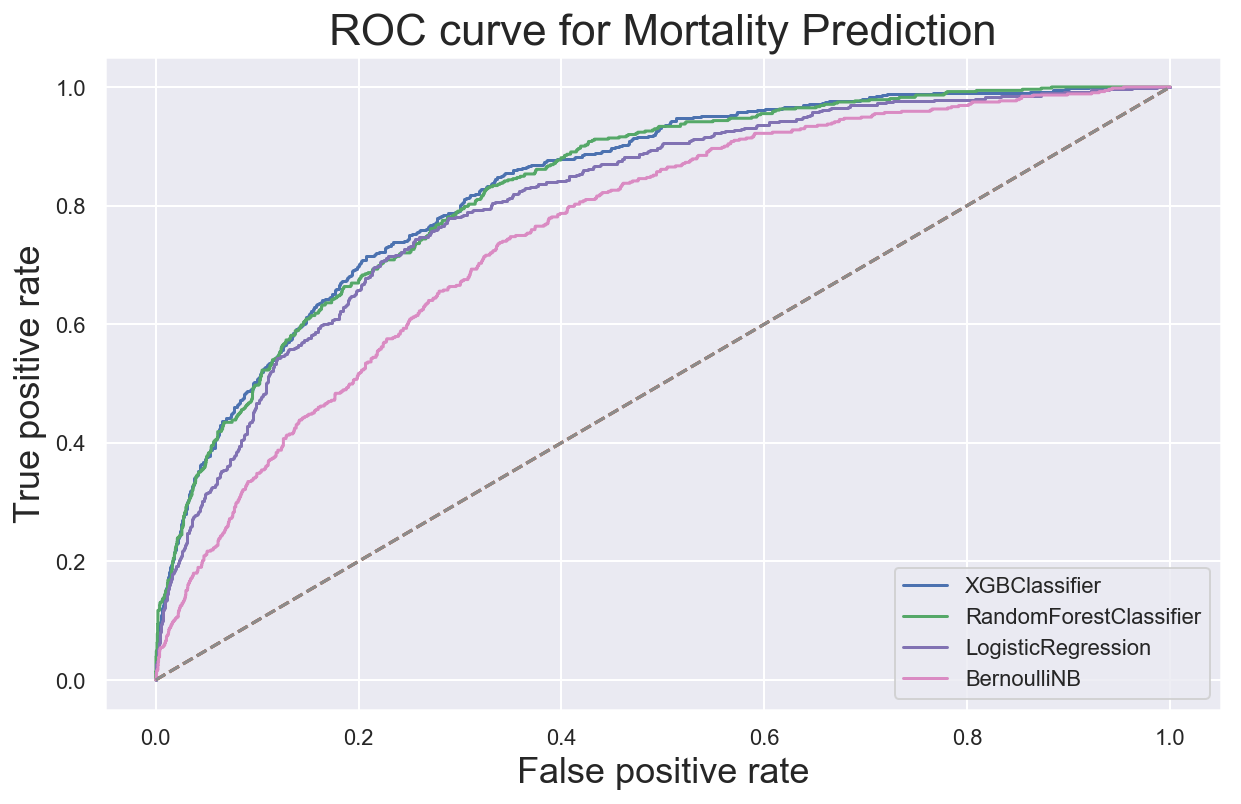

In [465]:
plot_AUC(X_te, y_test, xgb)
plot_AUC(X_te, y_test, rf_all)
plot_AUC(X_te, y_test,logit)
plot_AUC(X_te, y_test,nb_all)

### And finally, as a sanity check, let's compare with a dummy classifier.

In [372]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB

In [373]:
dc = DummyClassifier()
dc.fit(X_tr, y_train)
max_score(dc, X_te, y_test)

[0.1851145038167939, 0.44939999999999997]

Don't repeat the ps
what is the solution in starting two slides
How are you solving it (architecture diagram)
Demo
Summarize